## Pan @ Clef 2020 Author profiling task: Profiling Fake News Spreaders on Twitter.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Importing all the necessary libraries

In [40]:
# Necesary to install and use POLYGLOT correctly:
!apt-get -qq install python-numpy libicu-dev
!apt-get -qq install build-essential
!pip install -q PyICU
!pip install -q pycld2
!pip install morfessor
!pip install -q polyglot
!polyglot download embeddings2.en
!polyglot download pos2.en
!polyglot download ner2.en
!polyglot download sentiment2.en

# Install flatten_json
!pip install -q flatten-json

# NLTK stopwords
nltk.download('stopwords')


[polyglot_data] Downloading package embeddings2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package embeddings2.en is already up-to-date!
[polyglot_data] Downloading package pos2.en to /root/polyglot_data...
[polyglot_data]   Package pos2.en is already up-to-date!
[polyglot_data] Downloading package ner2.en to /root/polyglot_data...
[polyglot_data]   Package ner2.en is already up-to-date!
[polyglot_data] Downloading package sentiment2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.en is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
import os
import pickle
import pandas as pd
from xml.dom import minidom
from nltk.tokenize import RegexpTokenizer
import polyglot
from polyglot.text import Text, Word
from collections import Counter
import requests
import json
from flatten_json import flatten
import xml.etree.ElementTree as ET
import sys
from sklearn.model_selection import train_test_split
import statistics
import nltk 
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict


### Pre-processing the data

The following utility functions are used to:
- load the labels of the training data,
- get the set of stopwords, and
- clean the raw text by means of tokenization and elimination of stopwords. 

In [20]:
def loadTruthFile():
    truthfile = []
    with open("/content/drive/My Drive/WORK/UNED/PANCLEF/DATASET/truth_en.txt") as fh:
        for line in fh:
            userId, spreader = line.strip().split(':::')
            truthfile.append((userId, spreader.strip()))
    return truthfile

def getStopWords():
    stop_words = set()
    stop_words.add('user')
    stop_words.add('url')
    stop_words.add('htag')
    stop_words.add('hashtag')
    stop_words.add('#')
    stop_words.add('rt')
    stop_words.add('amp')
    stop_words.add('rcn')
    stop_words.add('lt')
    stop_words.add('de')
    stop_words.add('e')
    stop_words.add('la')
    stop_words.add('k')
    stop_words.add('v')
    stop_words.add('u')
    stop_words.add('th')
    stop_words.add('b')
    stop_words.add('gt')
    return stop_words

def cleanText(itemlist):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}')
    stop_words = getStopWords()
    tweets = []
    for tweet in itemlist:
        tokens = []
        for t in tokenizer.tokenize(tweet.lower()):
            if t not in stop_words: tokens.append(t)
        tweets.append(' '.join(tokens))
    return " ".join(tweets)

### Processing the data

In this section, we will define all the data processing. 

The model we propose takes into account several features in order to create a user profile. This features can be classified into 4 dimensions: 
- social and demographic,
- linguistic,
- based on social network activities, and
- based on shared content.

The social and demographic dimension includes the study of the personality of the user, as well as the analysis of the emotion of the texts posted online. 
The following functions make use of a 3rd-party API which, given a piece of text will return personality traits identified and the emotion detected (sentimen analysis), respectively. 

In [37]:
def getSymantosPersonality(user_id, text):

    url = 'https://api.symanto.net/dl/v1/bua'
    headers = {
    'Cache-Control': 'no-cache',
    'api_key': '3fb179561a6749ecaacbe20a7f1d057c',
    }
    body = [
    {
        "id": user_id,
        "text": text,
        "language": 'en'
    }
    ]

    x = requests.post(url, json = body, headers= headers)

    return x

def getSymantosSentiment(user_id, text, lang):

    url = 'https://api.symanto.net/dl/v1/sentiment'
    headers = {
    'Cache-Control': 'no-cache',
    'api_key': '3fb179561a6749ecaacbe20a7f1d057c',
    }
    body = [
    {
        "id": user_id,
        "text": text,
        "language": lang
    }
    ]

    x = requests.post(url, json = body, headers= headers)

    return x


def getSymantoDict(user_id, text):
    resultdict = {'userID':user_id,'personalities_prediction':0,'self_prediction':0,'info_prediction':0,'action_prediction':0,'fact_prediction':0,'sentiment_prediction':0}
    if len(text) > 2: 
        x = json.loads(getSymantosPersonality(user_id, text).text)
        y = json.loads(getSymantosSentiment(user_id, text, 'en').text)
        pers = flatten(x[0])
        sent = flatten(y[0])
        resultdict['personalities_prediction'] = 0 if pers['personalities_0_prediction'] == 'emotional' else 1
        resultdict['self_prediction'] = 0 if pers['self_0_prediction'] == 'no' else 1
        resultdict['info_prediction'] = 0 if pers['info_0_prediction'] == 'no' else 1
        resultdict['action_prediction'] = 0 if pers['action_0_prediction'] == 'no' else 1
        resultdict['fact_prediction'] = 0 if pers['fact_0_prediction'] == 'no' else 1
        resultdict['sentiment_prediction'] = 0 if sent['predictions_0_prediction'] == 'negative' else 1
    return resultdict


The following function makes use of Polyglot, a library designed to obtain linguistic features from text. With this function we obtain the values for the linguistic dimension of our model. 

In [19]:
def getPolyglotfeatures(text): 
    resultdict = {'num_DET': 0, 'num_ADJ': 0, 'num_ADP': 0, 'num_NOUN': 0, 'num_VERB': 0, 'num_PROPN': 0, 'num_NUM': 0, 'num_AUX': 0, 'num_ADV': 0, 'num_CONJ': 0, 'num_INTJ': 0, 'num_PART': 0, 'I-ORG': 0, 'I-LOC': 0, 'I-PER': 0, 'num_POS': 0, 'num_NEG': 0, 'num_NEUT': 0, 'num_words' : 0}
    if len(text) > 2: 
        zen = Text(text)
        zen.language = 'en'
        words = len(zen.words)
        resultdict['num_words'] = words
        ents = {'I-ORG' : 0, 'I-LOC': 0, 'I-PER' : 0}
        for entity in zen.entities:
            ents[entity.tag] += len(entity)
        pos_tag = list(map(list, zip(*zen.pos_tags)))[1]
        c = Counter(pos_tag)
        resultdict['num_DET'] = c['DET']/words
        resultdict['num_ADJ'] = c['ADJ']/words
        resultdict['num_ADP'] = c['ADP']/words
        resultdict['num_NOUN'] = c['NOUN']/words
        resultdict['num_VERB'] = c['VERB']/words
        resultdict['num_PROPN'] = c['PROPN']/words
        resultdict['num_NUM'] = c['NUM']/words
        resultdict['num_AUX'] = c['AUX']/words
        resultdict['num_ADV'] = c['ADV']/words
        resultdict['num_CONJ'] = c['CONJ']/words
        resultdict['num_INTJ'] = c['INTJ']/words
        resultdict['num_PART'] = c['PART']/words
        resultdict['I-ORG'] = ents['I-ORG']/words
        resultdict['I-LOC'] = ents['I-LOC']/words
        resultdict['I-PER'] = ents['I-PER']/words
        polarity = [w.polarity for w in zen.words]
        resultdict['num_POS'] = polarity.count(1)/words
        resultdict['num_NEG'] = polarity.count(-1)/words
        resultdict['num_NEUT'] = polarity.count(0)/words
    return resultdict


The activities of the user in social networks will be measured with the following function. For this task, we measure twitter activities in terms of: 
- Hashtag count
- Retweet count
- URL count
- Mention count
The reason for the election of this measurements is that the data is ofuscated due to privacy reasons. Therefore, this is the only "social-network information" available for the task.  

In [21]:

def getTwitterActionsFeatures(userID, itemlist):
    twitterDict = {'userID' : 0, 'num_htag' : 0, 'num_rt' : 0, 'num_url' : 0, 'num_user' : 0}
    twitterDict['userID'] = userID
 
    for tweet in itemlist:
        twitterDict['num_rt'] += 1 if tweet.startswith('RT') else 0
        twitterDict['num_htag'] += tweet.count('#HASHTAG#')
        twitterDict['num_url'] += tweet.count('#URL#')
        twitterDict['num_user'] += tweet.count('#USER#') 
    return twitterDict

In what regards the 4th dimension which contains data about what the user shares online. We have made a first approach by considering retweets as "shared content" as opposed to original content created by the user. Since most of the contents in retweets are news headlines, we have analysed the retweets as news headlines in order to identify them as fake or real news using the following function. 

In [41]:
def titleAnalyzer(itemlist):
    titleDict = {'all_caps' : 0, 'per_stop' : 0, 'num_propn' : 0}
    stop_words = nltk.corpus.stopwords.words('english')
    st = [] 
    for i in itemlist: 
        i = i.replace('#USER#', '').replace('#HASHTAG#','').replace('RT', '').replace('#URL#','')
        titleDict['all_caps'] += sum(map(str.isupper, i.split()))
        st.append(sum(map(lambda x: x in stop_words, i.split()))/len(i.split()))
        t = Text(i)
        t.language = 'en'
        titleDict['num_propn'] += len(t.entities)
    titleDict['per_stop'] = 0 if len(st) < 1 else round(statistics.mean(st),3)
    return titleDict

### Loading the data

The following function builds-up a Pandas DataFrame with the results of pre-processing and processing user data user by user. This DataFrame contains all the values that our system needs for training/prediction (except for the truth labels).

In [38]:
def getfilesContents(path):
    df = pd.DataFrame()
    entries = os.listdir(path)
    for entry in entries:
        user = entry[:-4]
        xmldoc = minidom.parse(path+'/'+entry)
        itemlist = list(map(lambda x: x.firstChild.wholeText, xmldoc.getElementsByTagName('document')))
        filteredTweets = list(filter(lambda x: (not x.startswith('RT')), itemlist))
        retweets = list(filter(lambda x: (x.startswith('RT')), itemlist))
        titleDict = titleAnalyzer(retweets)
        twitterDict = getTwitterActionsFeatures(user, itemlist)
        text = cleanText(filteredTweets)
        polyDict = getPolyglotfeatures(text)
        symantoDic = getSymantoDict(user, text)
        aux = {**symantoDic,**polyDict}
        aux1 = {**aux, **titleDict}
        features = {**aux1, **twitterDict}
        df = df.append([features])
    return df

Now that we have explained all the functions, let's load the data and save it to a `.csv` file in case we need it later. Let's also load the truth labels and prepare data for training. 

In [89]:
# df = getfilesContents("/content/drive/My Drive/WORK/UNED/PANCLEF/DATASET/en")
# df.to_csv('userDataDF.csv')
df = pd.read_csv('/content/drive/My Drive/DATASETS/userDataDF.csv')
truthdf = pd.DataFrame(loadTruthFile()).rename(columns = {0:'userID', 1:'score'})
scores = pd.merge(truthdf, df, on = 'userID')
X = scores.drop(['userID', 'score'], 1) # we don't need user ID nor truth label in this set.
y = scores['score'] # truth labels


### Training with different classifiers

For this experiment, we will use the following classifiers and compare their performances with cross-validation: 

- LogisticRegression
- KNeighborsClassifier
- RandomForestClassifier
- DecisionTreeClassifier
- SVC

In [92]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from statistics import mean 

def crossValidationModels(X, y):
    names = ['LogisticRegression','KNeighborsClassifier','RandomForestClassifier','DecisionTreeClassifier','SVC']
    lst = [LogisticRegression(solver='lbfgs',max_iter=10000), KNeighborsClassifier(), RandomForestClassifier(), DecisionTreeClassifier(), SVC()]
    resultdict = {}
    lst1 = []
    scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision'}
    for l, n  in zip(lst, names): 
        clf = l
        result = cross_validate(clf, X, y.values.ravel().astype(int), cv=5, scoring=scoring)
        a = result['test_accuracy'].mean()
        p = result['test_precision'].mean()
        r = result['test_recall'].mean()
        resultdict[n] = {'accuracy' : a , 'precision': p, 'recall': r}
    
    return resultdict

,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.610000,0.600000,0.683333,0.606667,0.620000
precision,0.603706,0.621918,0.700937,0.607228,0.606330
recall,0.646667,0.586667,0.640000,0.613333,0.773333


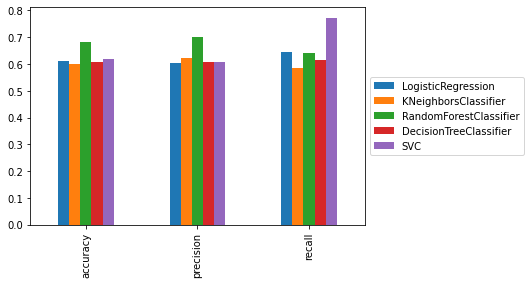

In [122]:
r = crossValidationModels(X, y)
DF = pd.DataFrame(r, index=["accuracy", 'precision', 'recall'])
DF.plot(kind='bar').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));
DF

Now, let's test each dimension separately. 

**1. Social & Demographical Dimension.**

We just use the following columns of the dataset: 
- personalities_prediction
- self_prediction
- info_prediction
- action_prediction
- fact_prediction
- sentiment_prediction


,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.573333,0.553333,0.620000,0.620000,0.600000
precision,0.575305,0.556499,0.625742,0.627334,0.595072
recall,0.560000,0.553333,0.586667,0.586667,0.613333


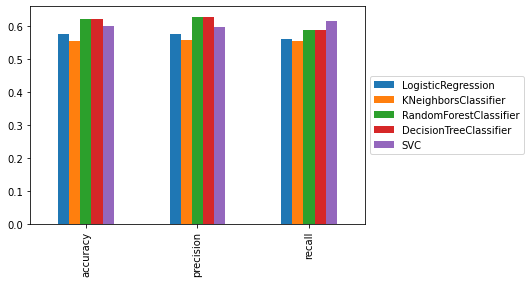

In [120]:
dim1 = X[['personalities_prediction', 'self_prediction', 'info_prediction', 'action_prediction', 'fact_prediction', 'sentiment_prediction']]
dim1Results = crossValidationModels(dim1, y)
df1 = pd.DataFrame(dim1Results, index=["accuracy", 'precision', 'recall'])
df1.plot(kind='bar').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));
df1

**2. Linguistic Dimension**

We will only use the following columns of the dataset: 
<table>
<tr>
<td>
<li>num_ADJ</li>
<li>num_DET</li>
<li>num_ADP</li>
<li>num_NOUN</li>
<li>num_VERB</li>
<li>num_PROPN</li>
<li>num_NUM </li>
</td>
<td>
<li>num_AUX</li>
<li>num_ADV</li>
<li>num_CONJ</li>
<li>num_INTJ</li>
<li>num_PART</li>
<li>I-ORG</li>
</td>
<td>
<li>I-LOC</li>
<li>I-PER</li>
<li>num_POS</li>
<li>num_NEG</li>
<li>num_NEUT</li>
<li>num_words</li>
</td>
</tr>
</table





,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.653333,0.553333,0.656667,0.583333,0.616667
precision,0.651058,0.556363,0.684467,0.588059,0.600095
recall,0.720000,0.540000,0.586667,0.573333,0.766667


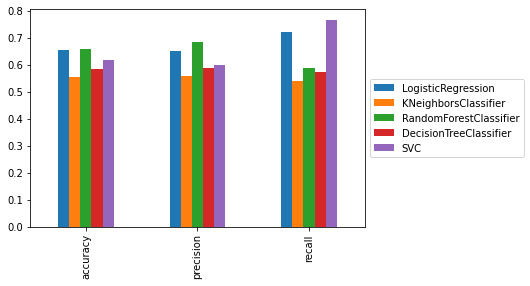

In [121]:
dim2 = X[['num_DET', 'num_ADJ', 'num_ADP', 'num_NOUN', 'num_VERB', 'num_PROPN', 'num_NUM', 'num_AUX', 'num_ADV', 'num_CONJ', 'num_INTJ', 'num_PART', 'I-ORG', 'I-LOC', 'I-PER', 'num_POS', 'num_NEG', 'num_NEUT', 'num_words']]
dim2Results = crossValidationModels(dim2, y)
df2 = pd.DataFrame(dim2Results, index=["accuracy", 'precision', 'recall'])
df2.plot(kind='bar').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));
df2

**3. Activity in social networks Dimension.**

We just use the following columns of the dataset:

- num_htag
- num_rt
- num_url
- num_user

,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.556667,0.530000,0.586667,0.553333,0.533333
precision,0.550952,0.525196,0.584250,0.550567,0.533038
recall,0.700000,0.553333,0.573333,0.553333,0.653333


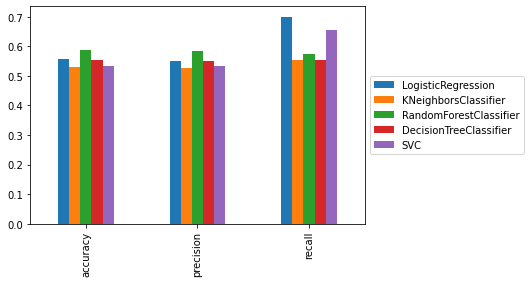

In [119]:
dim3 = X[['num_htag', 'num_rt', 'num_url', 'num_user']]
dim3Results = crossValidationModels(dim3, y)
df3 = pd.DataFrame(dim3Results, index=["accuracy", 'precision', 'recall'])
df3.plot(kind='bar').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));
df3


**4. Shared content online dimension**

We just use the following columns of the dataset:

- all_caps
- per_stop
- num_propn



,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.606667,0.553333,0.590000,0.573333,0.56000
precision,0.579799,0.484125,0.563214,0.549649,0.53726
recall,0.786667,0.660000,0.820000,0.853333,0.88000


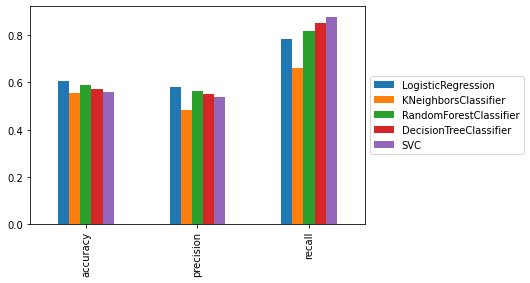

In [118]:
dim4 = X[['all_caps', 'per_stop', 'num_propn']]
dim4Results = crossValidationModels(dim4, y)
df4 = pd.DataFrame(dim4Results, index=["accuracy", 'precision', 'recall'])
df4.plot(kind='bar').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));
df4


Now, let's try different combinations of the dimensions: 

In [131]:
dim1_2 = pd.concat([dim1, dim2], axis=1, ignore_index=True)
dim1_2Results = crossValidationModels(dim1_2, y)
df1_2 = pd.DataFrame(dim1_2Results, index=["accuracy", 'precision', 'recall'])
df1_2

,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.616667,0.553333,0.670000,0.586667,0.616667
precision,0.613006,0.556494,0.704778,0.595944,0.599857
recall,0.646667,0.540000,0.593333,0.546667,0.773333


In [130]:
dim1_3 = pd.concat([dim1, dim3], axis=1, ignore_index=True)
dim1_3Results = crossValidationModels(dim1_3, y)
df1_3 = pd.DataFrame(dim1_3Results, index=["accuracy", 'precision', 'recall'])
df1_3

,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.580000,0.533333,0.566667,0.563333,0.546667
precision,0.570255,0.526323,0.570023,0.565478,0.545478
recall,0.653333,0.593333,0.546667,0.540000,0.673333


In [129]:
dim1_4 = pd.concat([dim1, dim4], axis=1, ignore_index=True)
dim1_4Results = crossValidationModels(dim1_4, y)
df1_4 = pd.DataFrame(dim1_4Results, index=["accuracy", 'precision', 'recall'])
df1_4

,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.583333,0.536667,0.596667,0.546667,0.56000
precision,0.580370,0.522221,0.587373,0.543203,0.53726
recall,0.593333,0.540000,0.653333,0.600000,0.88000


In [132]:
dim2_3 = pd.concat([dim2, dim3], axis=1, ignore_index=True)
dim2_3Results = crossValidationModels(dim2_3, y)
df2_3 = pd.DataFrame(dim2_3Results, index=["accuracy", 'precision', 'recall'])
df2_3

,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.596667,0.596667,0.706667,0.620000,0.620000
precision,0.583019,0.619456,0.741488,0.635496,0.607787
recall,0.733333,0.580000,0.640000,0.586667,0.766667


In [133]:
dim2_4 = pd.concat([dim2, dim4], axis=1, ignore_index=True)
dim2_4Results = crossValidationModels(dim2_4, y)
df2_4 = pd.DataFrame(dim2_4Results, index=["accuracy", 'precision', 'recall'])
df2_4

,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.623333,0.550000,0.703333,0.610000,0.616667
precision,0.618655,0.553904,0.742407,0.620406,0.600095
recall,0.686667,0.533333,0.653333,0.560000,0.766667


In [134]:
dim3_4 = pd.concat([dim3, dim4], axis=1, ignore_index=True)
dim3_4Results = crossValidationModels(dim3_4, y)
df3_4 = pd.DataFrame(dim3_4Results, index=["accuracy", 'precision', 'recall'])
df3_4

,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC
accuracy,0.586667,0.536667,0.566667,0.556667,0.543333
precision,0.573867,0.533452,0.565374,0.558480,0.542444
recall,0.686667,0.546667,0.553333,0.553333,0.660000
